# Social Network Analysis applied to Data Warehouses

## 4. Network Connectivity Analysis: Clustering

The **clustering coefficient** is the number of links between a node and its adjacent ones, divided by the number of links that might exist between them. This measure shows how much the adjacent nodes would remain connected without the node itself. Zinoviev (2018) describes the clustering coefficient as a measure of "stardom." If the clustering coefficient of a node is 1, the node participates in every possible triangle involving any pair of its neighbors. If the clustering coefficient of a node is 0, no two nodes in the neighborhood are connected. Therefore, tables with lower clustering coefficients are more critical in the Data Warehouse context.

### 4.1. Import dependencies

In [1]:
import itertools
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
from networkx.classes.graph import Graph
import numpy as np
import pandas as pd
from pandas import Series

### 4.2. Utility functions

In [2]:
def load_graph_from_csv(file: str) -> Graph:
    return nx.read_edgelist(file, delimiter=",", create_using=nx.DiGraph)

In [3]:
def format_graph_info(graph_id: str, graph: Graph) -> str:
    return (
        f"{graph_id.upper()} GRAPH INFO:\n"
        f"  Number of nodes: {nx.number_of_nodes(graph)}\n"
        f"  Number of edges: {nx.number_of_edges(graph)}\n"
        f"  Density: {nx.density(graph)}\n"
        f"  Average clustering coefficient: {nx.average_clustering(graph)}\n"
        f"  Transitivity: {nx.transitivity(graph)}"
    )

In [4]:
def get_clustering(graph: Graph) -> Dict[str, float]:
    return nx.clustering(graph)

In [5]:
def get_clustering_list(clustering: Dict[str, float]) -> List[float]:
    return [clust_coef for _, clust_coef in clustering.items()]

In [6]:
def get_clustering_series(clustering: Dict[str, float]) -> Series:
    return pd.Series(get_clustering_list(clustering))

In [7]:
def draw_clustering_based_network(graph: Graph, clustering: Dict[str, float]) -> None:
    sorted_clustering = sorted(get_clustering_list(clustering))

    lowest_non_zero_clust_coef = next(
        clust_coef for clust_coef in sorted_clustering if clust_coef > 0
    )
    highest_clust_coef = sorted_clustering[-1]
    scaling_factor = 3500 / highest_clust_coef

    normalized_node_params = [
        (clust_coef or (lowest_non_zero_clust_coef / 10)) * scaling_factor
        for clust_coef in sorted_clustering
    ]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph),
        with_labels=False,
        edge_color="dimgray",
        node_color=normalized_node_params,
        node_size=normalized_node_params,
    )
    plt.axis("off")

In [8]:
def plot_clustering_descriptive_stats(clustering: Dict[str, float], color: str) -> None:
    clustering_list = get_clustering_list(clustering)

    plt.figure(figsize=(12, 3))
    plt.boxplot(clustering_list, vert=False, flierprops=dict(markerfacecolor=color))
    plt.xlabel("Clustering")

In [9]:
def plot_clustering_ranking(
    clustering: Dict[str, float], fmt: str, stop_at: Optional[float] = None
) -> None:
    sorted_clustering = sorted(get_clustering_list(clustering))

    stop_at_index = 0
    if stop_at is None:
        stop_at_index = len(sorted_clustering) - 1
    else:
        stop_at_index = sorted_clustering.index(stop_at)
        while sorted_clustering[stop_at_index] == sorted_clustering[stop_at_index + 1]:
            stop_at_index += 1

    adjusted_list = [None]
    adjusted_list.extend(sorted_clustering[: stop_at_index + 1])

    plt.figure(figsize=(12, 3))
    plt.plot(adjusted_list, fmt)
    plt.xlabel("Rank")
    plt.ylabel("Clustering Coefficient")

In [10]:
def group_nodes_by_clustering(clustering: Dict[str, float]) -> Dict[float, List[str]]:
    clustering_list = get_clustering_list(clustering)
    unique_clustering = sorted(np.unique(clustering_list))
    sorted_clustering_dict = {}
    for value in unique_clustering:
        sorted_clustering_dict[value] = sorted(
            [node for node, cl in clustering.items() if cl == value]
        )
    return sorted_clustering_dict

In [11]:
def get_clustering_critical_nodes_for_count(
    clustering: Dict[str, float], target_node_count
) -> Tuple[Dict[int, List[str]], float]:
    node_count = 0
    cl_groups = group_nodes_by_clustering(clustering)

    group_count = 0
    while node_count < target_node_count:
        group_count += 1
        lowest_cl = dict(itertools.islice(cl_groups.items(), group_count))
        node_count = sum([len(nodes) for _, nodes in lowest_cl.items()])

    print(f"{group_count}-critical-groups node count: {node_count}\n")

    return lowest_cl, node_count

In [12]:
def plot_clustering_bars(out_degrees: Dict[int, List[str]], graph: Graph) -> None:
    nodes = []
    clustering = []
    for degree, nodes_list in out_degrees.items():
        for node in nodes_list:
            nodes.append(node)
            clustering.append(nx.clustering(graph, node))

    colors = plt.cm.viridis(np.random.rand(len(nodes)))

    plt.figure(figsize=(12, 3))
    plt.bar(nodes, clustering, label=nodes, color=colors)
    plt.xlabel("Node")
    plt.xticks(rotation=50)
    plt.ylabel("Clustering Coefficient")
    plt.show()

In [13]:
def plot_clustering_versus_out_degree(
    out_degrees: Dict[int, List[str]], graph: Graph, min_degree_for_text: int
) -> None:
    nodes = []
    degrees = []
    clustering = []
    for degree, nodes_list in out_degrees.items():
        for node in nodes_list:
            nodes.append(node)
            degrees.append(degree)
            clustering.append(nx.clustering(graph, node))

    colors = plt.cm.viridis(np.random.rand(len(degrees)))

    plt.figure(figsize=(12, 8))
    plt.scatter(degrees, clustering, s=200, c=colors)
    for index in range(len(degrees)):
        if degrees[index] >= min_degree_for_text:
            plt.text(degrees[index], clustering[index], s=nodes[index])
    plt.xlabel("Out-degree")
    plt.ylabel("Clustering Coefficient")
    plt.ylim([-0.005, max(clustering) + 0.04])
    plt.show()

### 4.3. Load the anonymized graphs from CSV and cache their Clustering data

In [14]:
anon_data_folder = "../data/anonymized"

small_graph_1 = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-small_1.csv")
print(f'{format_graph_info("small(1)", small_graph_1)}\n')

small_graph_2 = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-small_2.csv")
print(f'{format_graph_info("small(2)", small_graph_2)}\n')

medium_graph = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-medium.csv")
print(f'{format_graph_info("medium", medium_graph)}\n')

large_graph = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-large.csv")
print(f'{format_graph_info("large", large_graph)}')

SMALL(1) GRAPH INFO:
  Number of nodes: 827
  Number of edges: 904
  Density: 0.0013233748400678083
  Average clustering coefficient: 0.008543182152613835
  Transitivity: 0.0034873583260680036

SMALL(2) GRAPH INFO:
  Number of nodes: 658
  Number of edges: 1400
  Density: 0.003238446840895107
  Average clustering coefficient: 0.12371040219915662
  Transitivity: 0.06696664902064585

MEDIUM GRAPH INFO:
  Number of nodes: 8298
  Number of edges: 9458
  Density: 0.00013737407751447794
  Average clustering coefficient: 0.005819181276085573
  Transitivity: 0.012780414150129421

LARGE GRAPH INFO:
  Number of nodes: 14511
  Number of edges: 24990
  Density: 0.00011868654882455435
  Average clustering coefficient: 0.04760245618981202
  Transitivity: 0.0035961744144591013


In [15]:
small_graph_1_cl = get_clustering(small_graph_1)
small_graph_2_cl = get_clustering(small_graph_2)
medium_graph_cl = get_clustering(medium_graph)
large_graph_cl = get_clustering(large_graph)

### 4.4. Draw the networks, plot Clustering data, etc

#### 4.4.1. Small network 1

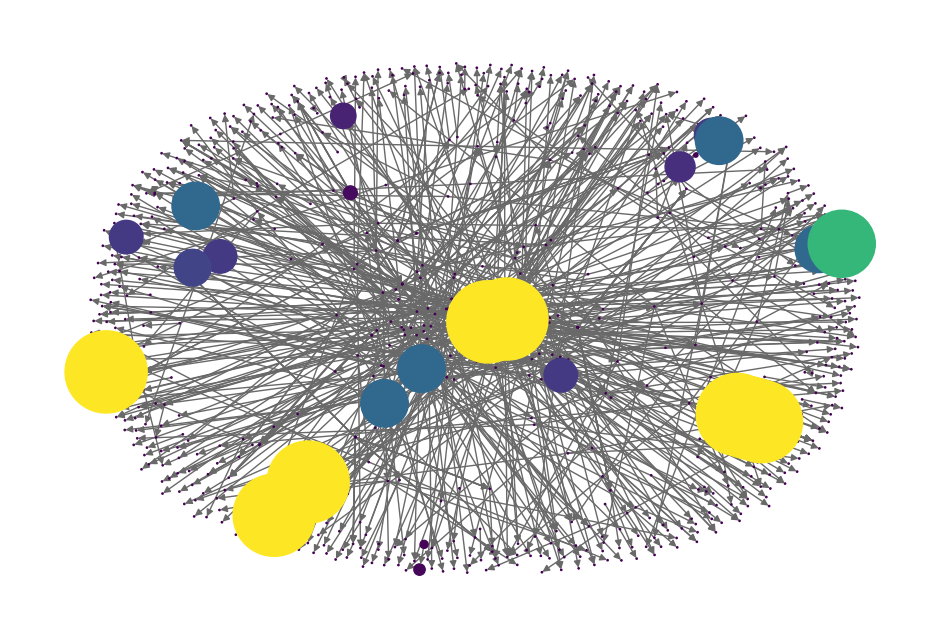

In [16]:
draw_clustering_based_network(small_graph_1, small_graph_1_cl)

In [17]:
sg_1_clustering_series = get_clustering_series(small_graph_1_cl)
print(sg_1_clustering_series.describe())

count    827.000000
mean       0.008543
std        0.056478
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
dtype: float64


Different from what was observed in the out-degree and betweenness centrality analyses, the research shows that the clustering coefficient, per se, is not a convenient metric to determine critical assets in Data Warehouses. This is because many assets have the same clustering coefficient in each dataset. The first clue about this behavior comes from the standard deviations, close to zero, in all datasets

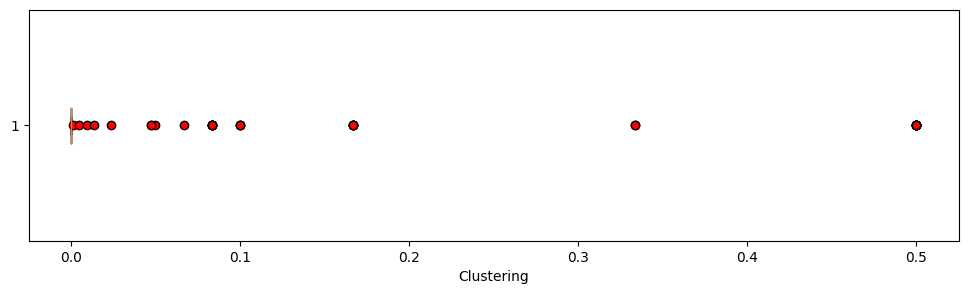

In [18]:
plot_clustering_descriptive_stats(small_graph_1_cl, "red")

It becomes more evident when trying to rank the assets according to the clustering coefficient, using a similar approach from the previous analyses but using ascending order in this specific case. The below chart illustrates a pattern found in all four datasets: A considerable number of assets with clustering coefficients equal to zero, making it impractical to determine the most important ones relying solely on this metric.

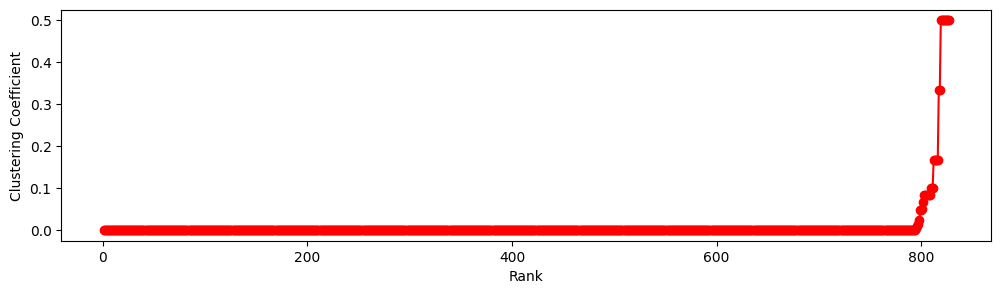

In [19]:
plot_clustering_ranking(small_graph_1_cl, "ro-")

In [20]:
sg_1_critical_groups, _ = get_clustering_critical_nodes_for_count(small_graph_1_cl, 10)

1-critical-groups node count: 793



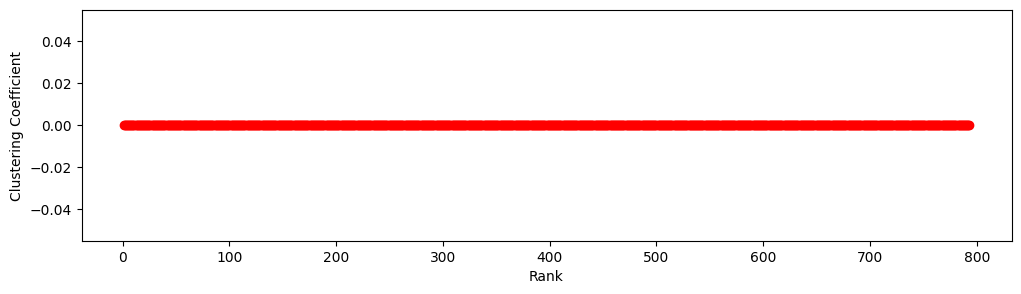

In [21]:
plot_clustering_ranking(
    small_graph_1_cl,
    "ro-",
    stop_at=list(sg_1_critical_groups.keys())[-1],
)

In [22]:
sg1_highest_out_degrees = {
    27: ["10007"],
    25: ["10025"],
    15: ["10060"],
    14: ["10020"],
    13: ["10131"],
    12: ["10014", "10275", "10373"],
    11: ["10059", "10115"],
    10: ["10062", "10073", "10085", "10191"],
}

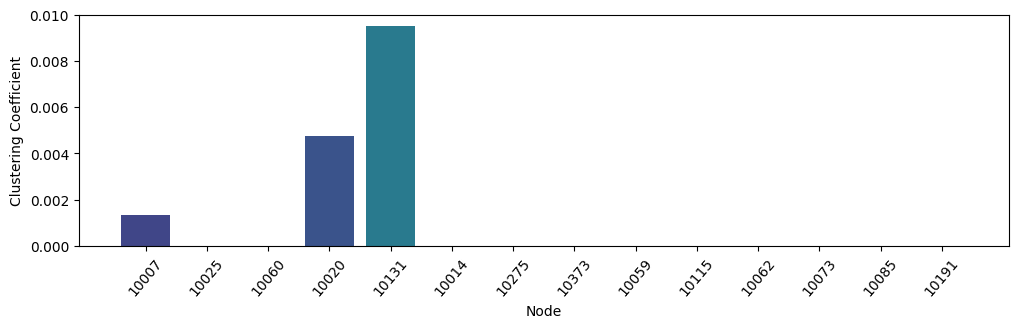

In [23]:
plot_clustering_bars(sg1_highest_out_degrees, small_graph_1)

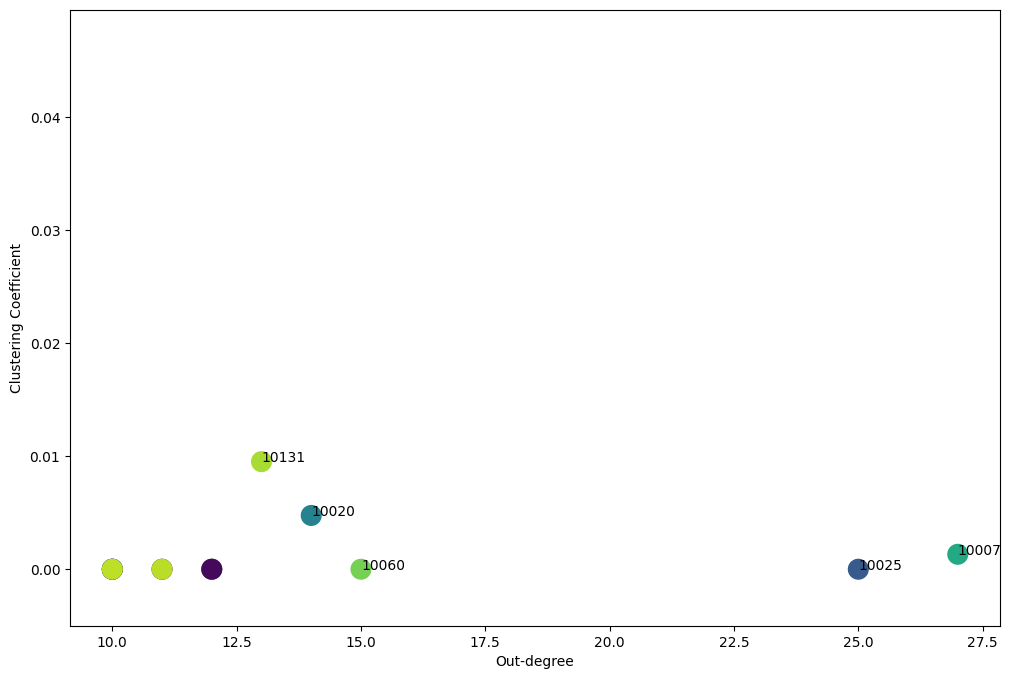

In [24]:
plot_clustering_versus_out_degree(
    sg1_highest_out_degrees, small_graph_1, min_degree_for_text=13
)

#### 4.4.2. Small network 2

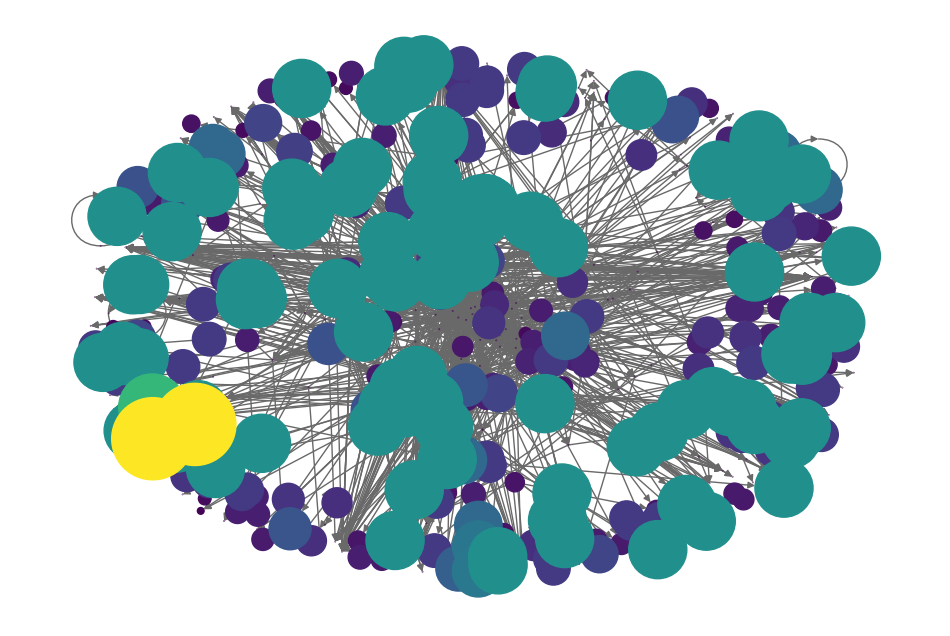

In [25]:
draw_clustering_based_network(small_graph_2, small_graph_2_cl)

In [26]:
sg_2_clustering_series = get_clustering_series(small_graph_2_cl)
print(sg_2_clustering_series.describe())

count    658.000000
mean       0.123710
std        0.182171
min        0.000000
25%        0.000000
50%        0.037121
75%        0.166667
max        1.000000
dtype: float64


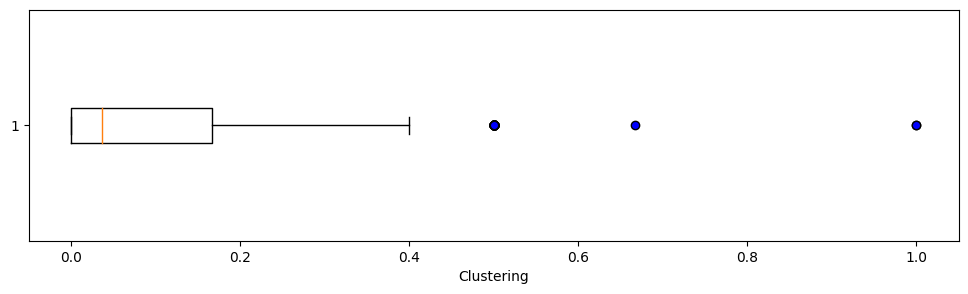

In [27]:
plot_clustering_descriptive_stats(small_graph_2_cl, "blue")

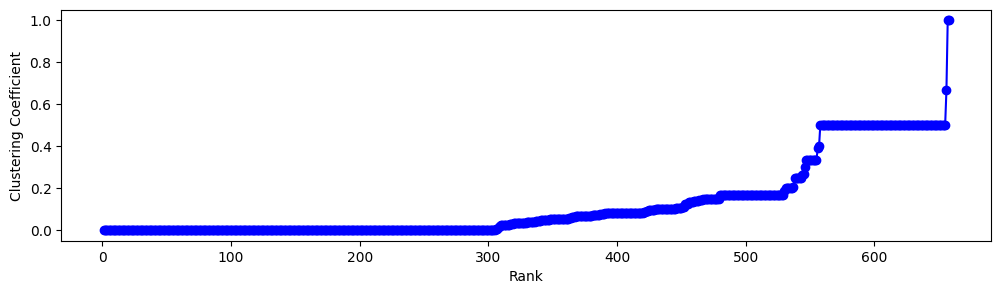

In [28]:
plot_clustering_ranking(small_graph_2_cl, "bo-")

In [29]:
sg_2_critical_groups, _ = get_clustering_critical_nodes_for_count(small_graph_2_cl, 10)

1-critical-groups node count: 303



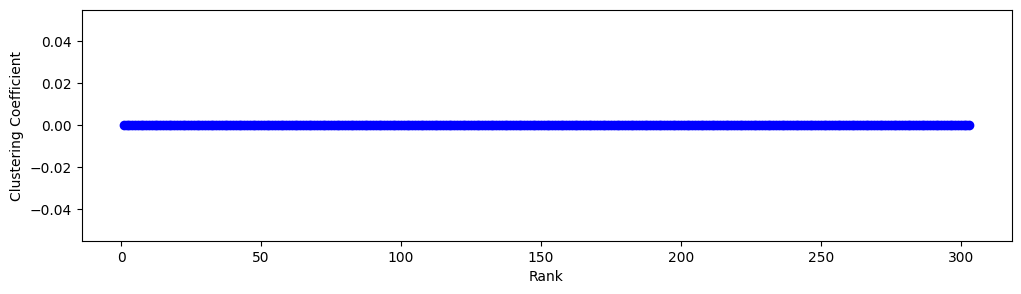

In [30]:
plot_clustering_ranking(
    small_graph_2_cl,
    "bo-",
    stop_at=list(sg_2_critical_groups.keys())[-1],
)

In [31]:
sg2_highest_out_degrees = {
    19: ["20026"],
    15: ["20040", "20044", "20101", "20295"],
    14: ["20071", "20110", "20214", "20349"],
    13: ["20017", "20069", "20098", "20168", "20184"],
    12: ["20174", "20332"],
    11: ["20031", "20086", "20094", "20136", "20229"],
    10: [
        "20012",
        "20030",
        "20049",
        "20074",
        "20109",
        "20145",
        "20158",
        "20283",
        "20350",
        "20379",
    ],
}

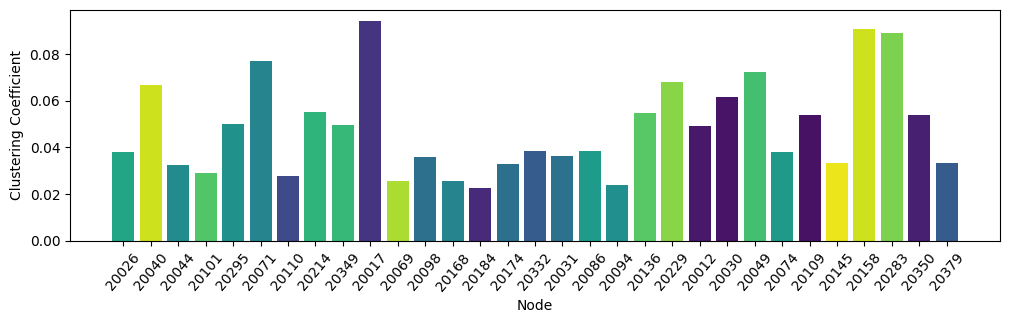

In [32]:
plot_clustering_bars(sg2_highest_out_degrees, small_graph_2)

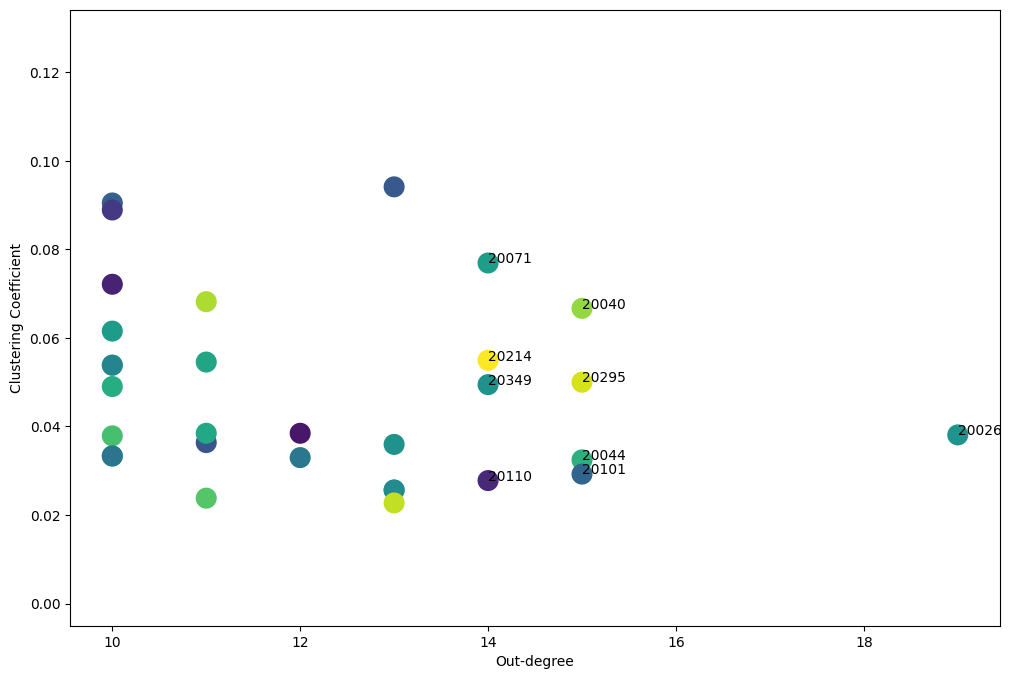

In [33]:
plot_clustering_versus_out_degree(
    sg2_highest_out_degrees, small_graph_2, min_degree_for_text=14
)

In [34]:
nodes = []
clustering = []
for degree, nodes_list in sg2_highest_out_degrees.items():
    for node in nodes_list:
        print(
            f"Node {node}'s clustering coefficient: {nx.clustering(small_graph_2, node)}"
        )

Node 20026's clustering coefficient: 0.0380952380952381
Node 20040's clustering coefficient: 0.06666666666666667
Node 20044's clustering coefficient: 0.032454361054766734
Node 20101's clustering coefficient: 0.029239766081871343
Node 20295's clustering coefficient: 0.05
Node 20071's clustering coefficient: 0.07692307692307693
Node 20110's clustering coefficient: 0.027777777777777776
Node 20214's clustering coefficient: 0.054945054945054944
Node 20349's clustering coefficient: 0.04945054945054945
Node 20017's clustering coefficient: 0.09411764705882353
Node 20069's clustering coefficient: 0.02564102564102564
Node 20098's clustering coefficient: 0.03594771241830065
Node 20168's clustering coefficient: 0.02564102564102564
Node 20184's clustering coefficient: 0.022727272727272728
Node 20174's clustering coefficient: 0.03296703296703297
Node 20332's clustering coefficient: 0.038461538461538464
Node 20031's clustering coefficient: 0.03636363636363636
Node 20086's clustering coefficient: 0.03

#### 4.4.3. Medium network

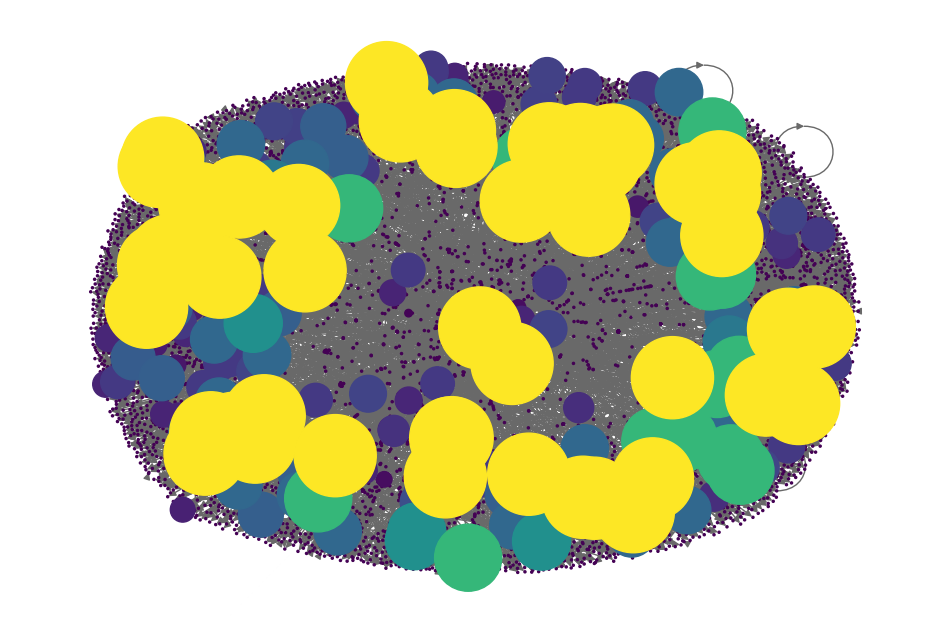

In [35]:
draw_clustering_based_network(medium_graph, medium_graph_cl)

In [36]:
mg_clustering_series = get_clustering_series(medium_graph_cl)
print(mg_clustering_series.describe())

count    8298.000000
mean        0.005819
std         0.043510
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.500000
dtype: float64


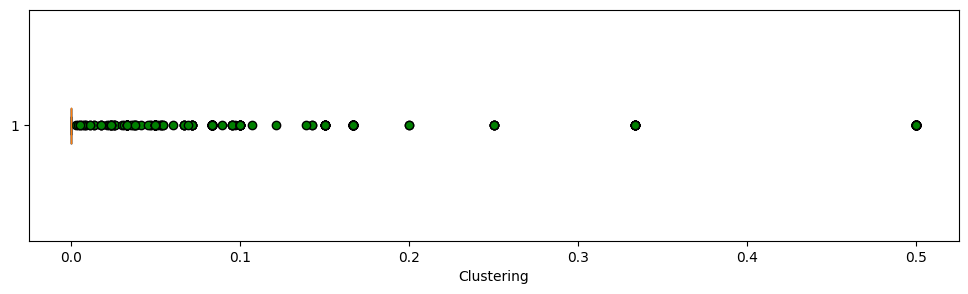

In [37]:
plot_clustering_descriptive_stats(medium_graph_cl, "green")

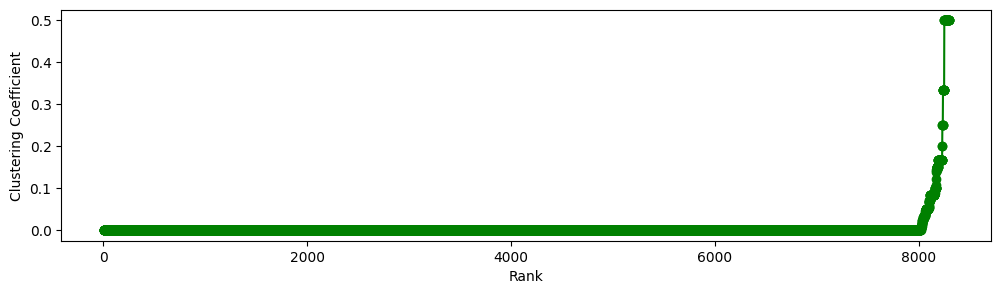

In [38]:
plot_clustering_ranking(medium_graph_cl, "go-")

In [39]:
mg_critical_groups, _ = get_clustering_critical_nodes_for_count(medium_graph_cl, 10)

1-critical-groups node count: 8019



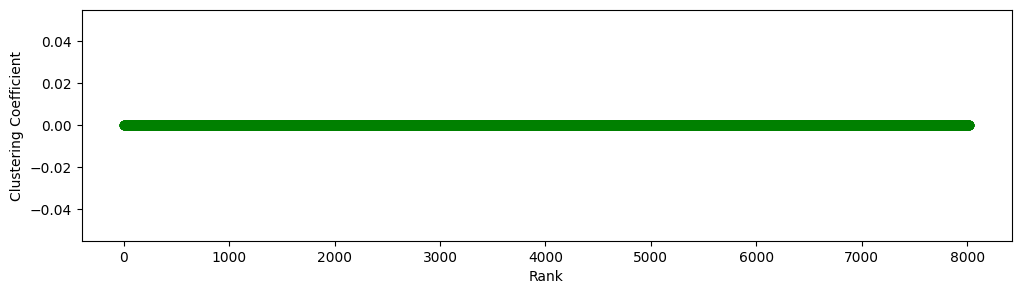

In [40]:
plot_clustering_ranking(
    medium_graph_cl,
    "go-",
    stop_at=list(mg_critical_groups.keys())[-1],
)

In [41]:
mg_highest_out_degrees = {
    48: ["301958"],
    34: ["300269"],
    16: ["300076", "300576"],
    15: ["301011"],
    14: ["300191", "300346"],
    13: ["300395", "300979"],
    12: ["300078", "301618", "302271", "303001", "304266"],
    11: ["300658", "302329", "303059"],
    10: [
        "300310",
        "300324",
        "300423",
        "300546",
        "300834",
        "300873",
        "301062",
        "301776",
        "302040",
        "302118",
        "302268",
        "302314",
        "302490",
        "302822",
        "303505",
    ],
}

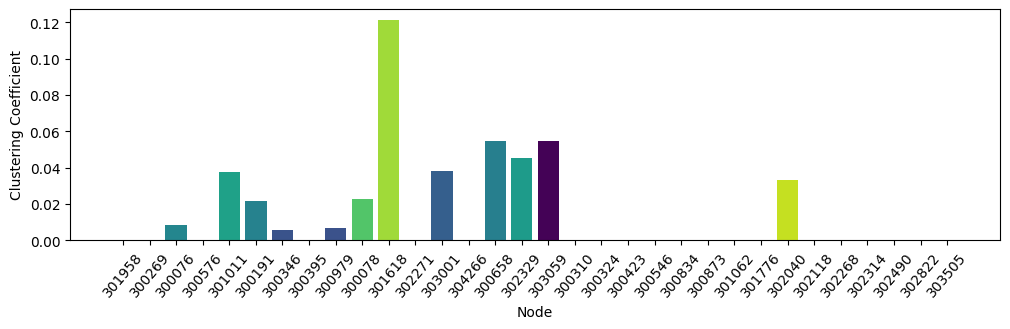

In [42]:
plot_clustering_bars(mg_highest_out_degrees, medium_graph)

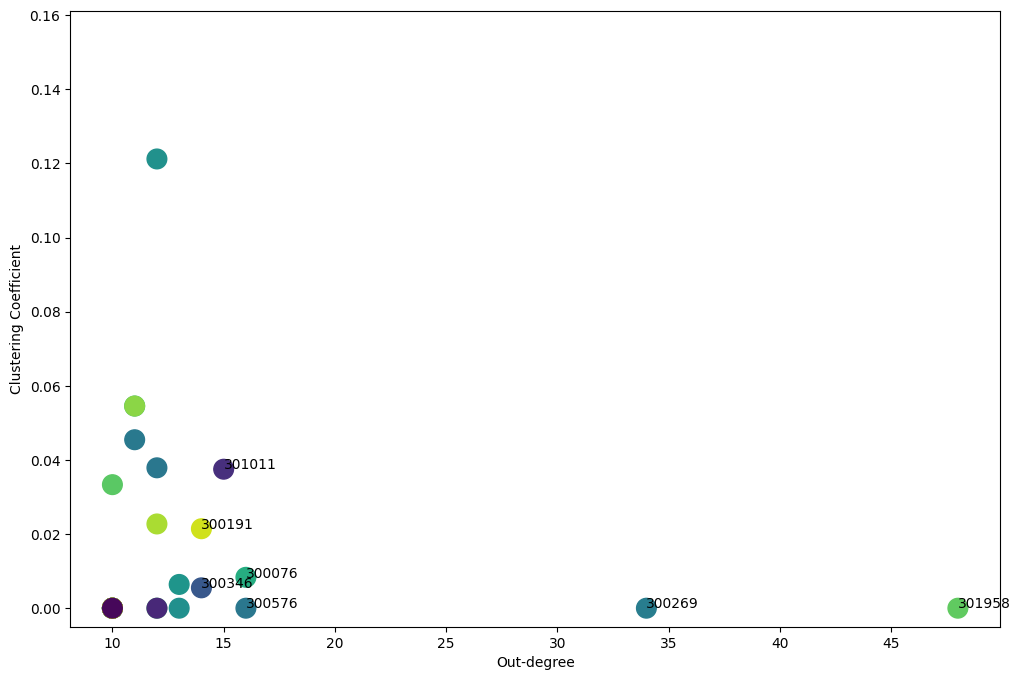

In [43]:
plot_clustering_versus_out_degree(
    mg_highest_out_degrees, medium_graph, min_degree_for_text=14
)

#### 4.4.4. Large network

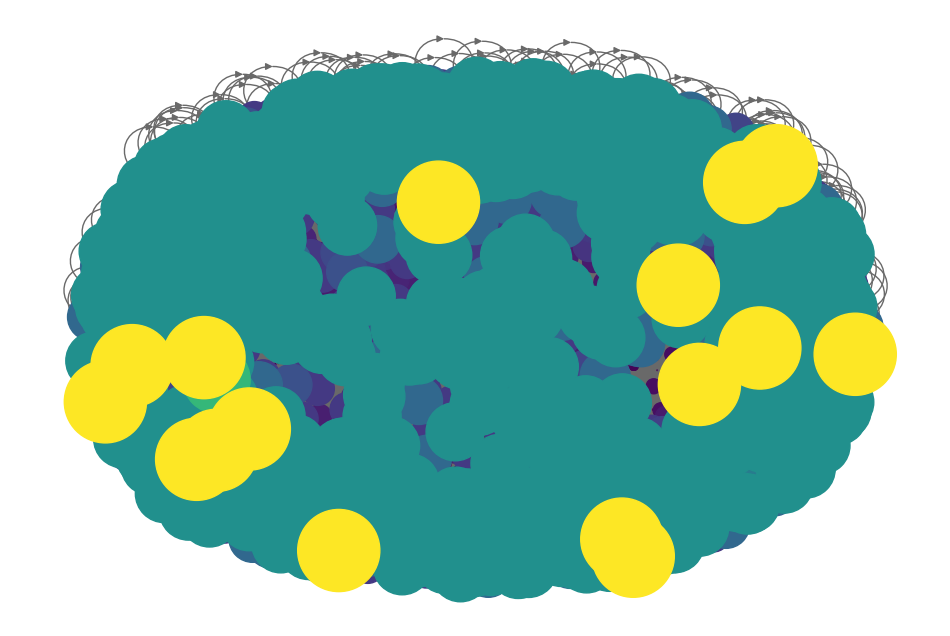

In [44]:
draw_clustering_based_network(large_graph, large_graph_cl)

In [45]:
lg_clustering_series = get_clustering_series(large_graph_cl)
print(lg_clustering_series.describe())

count    14511.000000
mean         0.047602
std          0.121858
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64


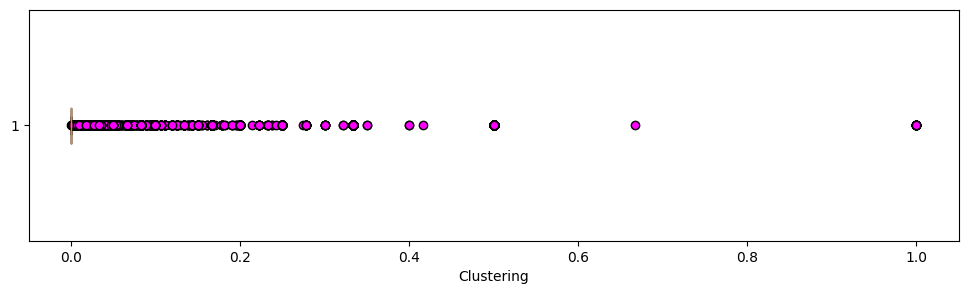

In [46]:
plot_clustering_descriptive_stats(large_graph_cl, "magenta")

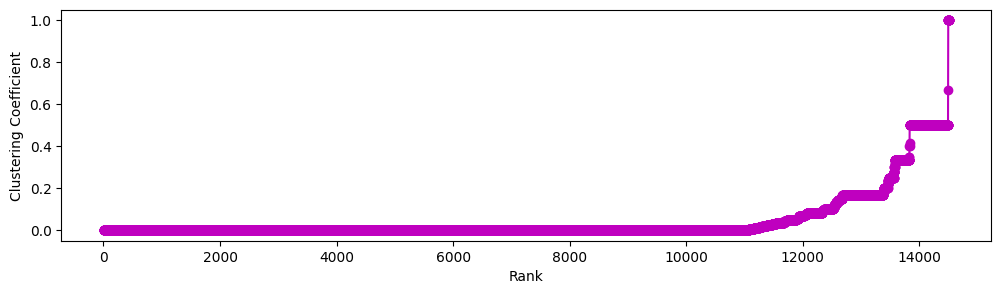

In [47]:
plot_clustering_ranking(large_graph_cl, "mo-")

In [48]:
lg_critical_groups, _ = get_clustering_critical_nodes_for_count(large_graph_cl, 10)

1-critical-groups node count: 11044



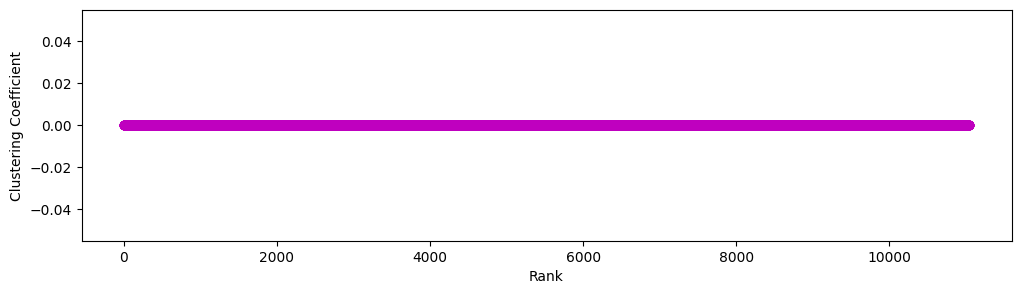

In [49]:
plot_clustering_ranking(
    large_graph_cl,
    "mo-",
    stop_at=list(lg_critical_groups.keys())[-1],
)

In [50]:
lg_highest_out_degrees = {
    692: ["4000092"],
    413: ["4000064"],
    241: ["4000015"],
    178: ["4000044"],
    139: ["4000766"],
    137: ["4000270"],
    132: ["4000272"],
    121: ["4000109"],
    111: ["4000995"],
    90: ["4000312"],
    83: ["4000562"],
    79: ["4000144", "4000473"],
    77: ["4000013"],
    74: ["4000157"],
    71: ["4000624"],
    68: ["4000094"],
    61: ["4000944"],
    60: ["4000118", "4000487"],
    59: ["4000492"],
    57: ["4001442"],
    54: ["4001822"],
    52: ["4000329"],
    49: ["4000426"],
    44: ["4000017", "4001955"],
    43: ["4001683"],
    42: ["4000011"],
    41: ["4000288"],
}

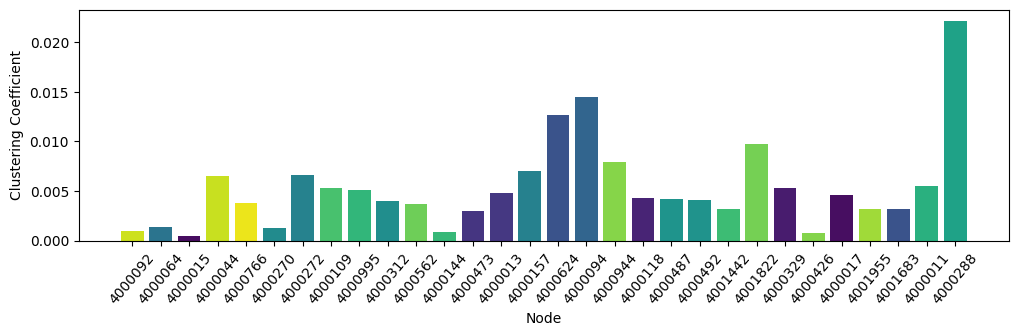

In [51]:
plot_clustering_bars(lg_highest_out_degrees, large_graph)

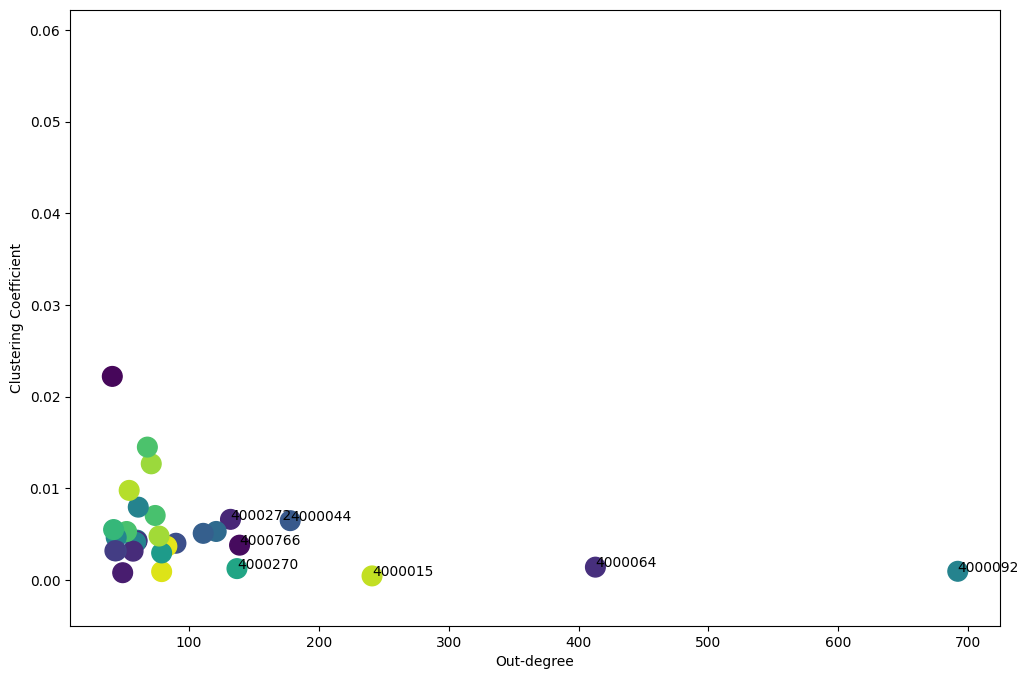

In [52]:
plot_clustering_versus_out_degree(
    lg_highest_out_degrees, large_graph, min_degree_for_text=130
)